Linear Regression

Read Data

In [1]:
import numpy as np
import pandas as pd
import math
import re

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


df_train = pd.read_csv('data/train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df_train_label = df_train[["Id", "SalePrice"]]
df_train = df_train.drop('SalePrice', axis=1)

df_train = df_train.set_index("Id")
df_train_label = df_train_label.set_index("Id")

df_test = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

test_null_columns=df_test.columns[df_test.isnull().any()] 
train_null_columns=df_train.columns[df_train.isnull().any()] 
test_null_only_ColIdx = test_null_columns.difference(train_null_columns)

test_null_only_RowIdx = [ df_test[df_test[idx].isnull()].index.tolist() for idx in test_null_only_ColIdx ]
test_null_only_RowIdx = list ( set(x for l in test_null_only_RowIdx for x in l) )

problematicTestSet = df_test.loc[ df_test.index.isin( test_null_only_RowIdx ) ]

fineTestSet = df_test.loc[ ~df_test.index.isin( test_null_only_RowIdx ) ]  #1447 records

problematicTestSet= problematicTestSet.set_index("Id")
fineTestSet = fineTestSet.set_index("Id")
df_test = df_test.set_index("Id")

df = pd.concat([df_train,df_test], axis=0, sort=True)

problematicTestSet.index

Int64Index([1556, 1916, 1946, 2121, 2152, 2189, 2217, 2251, 2474, 2490, 2577, 2905], dtype='int64', name='Id')

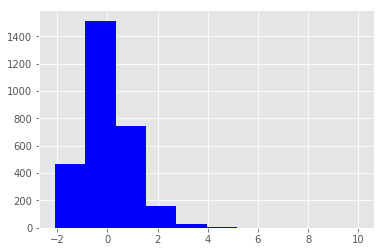

In [2]:
x = ( df["1stFlrSF"] - np.mean(df["1stFlrSF"]) ) / np.std(df["1stFlrSF"])
x.hist(color='b')

In [3]:
# Useful if you are debugging the function inside another .py script
%load_ext autoreload
%autoreload 2

Impute Data with preprocess.py subfunction

In [4]:
#After write everything as a function. This is how you call the impute function
from preprocess import impute
df_label_count, encodedDic = impute( df, False)  # label encode categorical data
df_onehot, _ = impute( df, True)  # onehot encode categorical data

In [5]:
df_test = df_onehot[df_onehot.index >= min(df_test.index)]
df_train = df_onehot[df_onehot.index < min(df_test.index)]

print( df_train.shape )
print( df_test.shape )

(1460, 255)
(1459, 255)


In [6]:
df_train_label = df_train_label.astype(int)
df_train_label_log = np.log1p( df_train_label )

#plt.rcParams['figure.figsize'] = (5.0, 5.0)
#df_train_label.hist()
#df_train_label_log.hist()

### Basic Models

1127988938211.1147
2947057046840.1406
[1.48653561e+07 7.86876737e+08 1.37383322e+11 1.66088454e-01
 2.29979271e+09 7.98439161e+11 3.79150393e+11 1.03177198e-01
 2.32858851e+10 9.93852909e+12]


Text(0,0.5,'log (RMSE)')

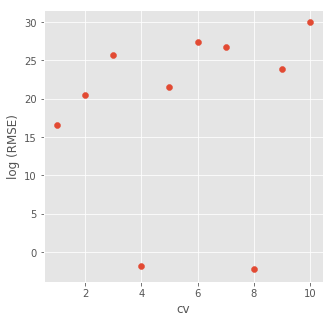

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

lm_l = linear_model.LinearRegression(normalize=True)

cvrmse = np.sqrt(-cross_val_score( lm_l , df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10) )
print( cvrmse.mean() )
print( cvrmse.std() )
print( cvrmse )
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.scatter(range(1, 11), np.log( cvrmse ) )
plt.xlabel ("cv")
plt.ylabel ("log (RMSE)")

In [8]:
lm_l = linear_model.LinearRegression(normalize=True)
lm_l.fit(df_train, df_train_label_log)
d = { 'SalePrice': np.expm1 ( lm_l.predict(df_test).ravel() )    }
sub = pd.DataFrame(data = d, dtype=np.int64, index = df_test.index )
sub.to_csv('Linear.csv')

### GridSearchCV looking for best regulaization factor for different regression models.
- Lasso
- Ridge
- ElasticNet

Lasso

In [9]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


{'alpha': 0.00012045035402587823} 0.016204864627912815


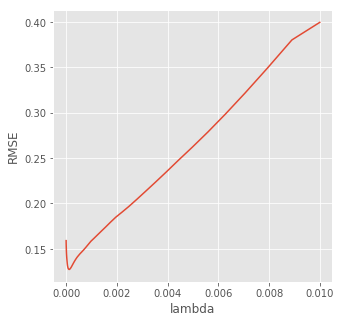

In [10]:
alphas = np.logspace(-7, -2, 100)

grid = GridSearchCV(estimator=Lasso(normalize=True),
    param_grid=dict(alpha=alphas), cv=5, scoring='neg_mean_squared_error' ) # scoring='r2'

grid.fit(df_train, df_train_label_log) # entire datasets were fed here

print (grid.best_params_, -grid.best_score_)

#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
scores = [np.sqrt(-x) for x in grid.cv_results_['mean_test_score'] ]
plt.plot(alphas, scores)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.show()

# the lambda is very small. Therefore, there is almost no regulization going on.


In [11]:
def evaluate(model, test_features, test_labels): 
    
    predictions = model.predict(test_features).ravel() 
    residuals = test_labels - predictions
    
    rmse = np.sqrt( np.mean( (test_labels - predictions) ** 2 ) )
    
    rmsle = np.sqrt( np.mean((np.log1p(predictions) - np.log1p(test_labels))**2) ) 
    
    pred = pd.DataFrame( {'residuals': residuals.values, 'predictions': predictions} )
    pred.set_index(residuals.index)
    
    return [rmse, rmsle, pred]

RMSE = 0.1514
RMSLE = 0.0114


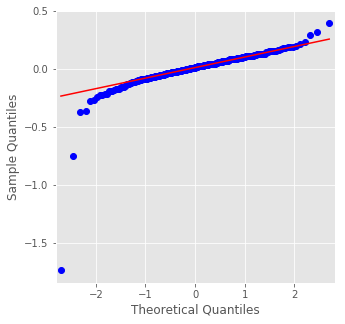

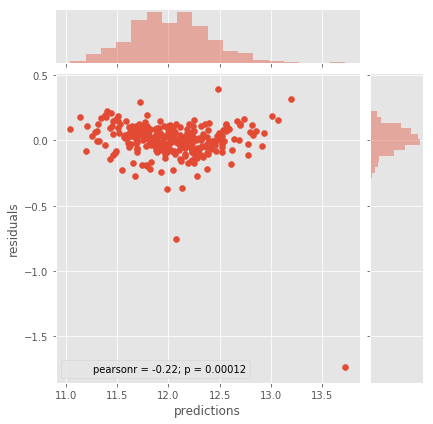

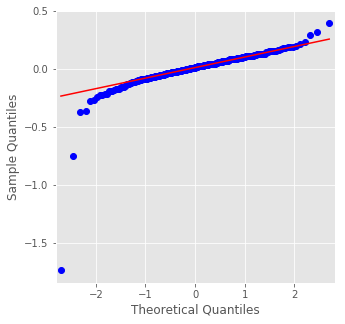

In [12]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=0)

model_lasso = Lasso(alpha= grid.best_params_['alpha'], normalize=True)
#model_lasso.fit(X_train, y_train)
model_lasso.fit(X_train, y_train)

rmse, rmsle, pred = evaluate(model_lasso, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

import statsmodels.api as sm
sm.qqplot(pred.residuals,line='q')

In [13]:
model_lasso = Lasso(alpha= grid.best_params_['alpha'], normalize=True)
cvrmse = np.sqrt(-cross_val_score( model_lasso , df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10) )
print( cvrmse.mean() )
print( cvrmse.std() )
cvrmse

0.12499434035165242
0.02314834053875297


array([0.12297128, 0.09276772, 0.1100192 , 0.15770432, 0.14016485,
       0.10388656, 0.11870339, 0.10796128, 0.16988809, 0.12587672])

Lasso picked 79 variables and eliminated the other 176 variables


Text(0.5,1,'Coefficients in the Lasso Model')

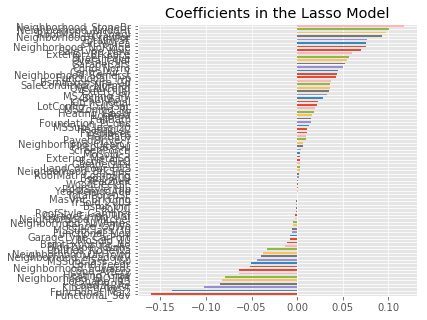

In [14]:
model_lasso.fit(df_train, df_train_label_log)
coef = pd.Series(model_lasso.coef_, index = df_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
plt.figure()
plt.rcParams['figure.figsize'] = (5.0, 36.0)

imp_coef = pd.concat([coef[coef != 0].sort_values()])

#imp_coef = pd.concat([coef[coef != 0].sort_values().head(20),
#                     coef[coef != 0].sort_values().tail(20)])


imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


In [15]:
model_lasso = Lasso(alpha= grid.best_params_['alpha'], normalize=True)
model_lasso.fit(df_train, df_train_label_log)

Lasso(alpha=0.00012045035402587823, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
d = {  'SalePrice': np.expm1 ( model_lasso.predict(df_test) )    }
sub = pd.DataFrame(data = d, dtype=np.int64, index = df_test.index )
sub.to_csv('Lasso.csv')


Ridge

{'alpha': 0.2848035868435805} 0.01788145751093603


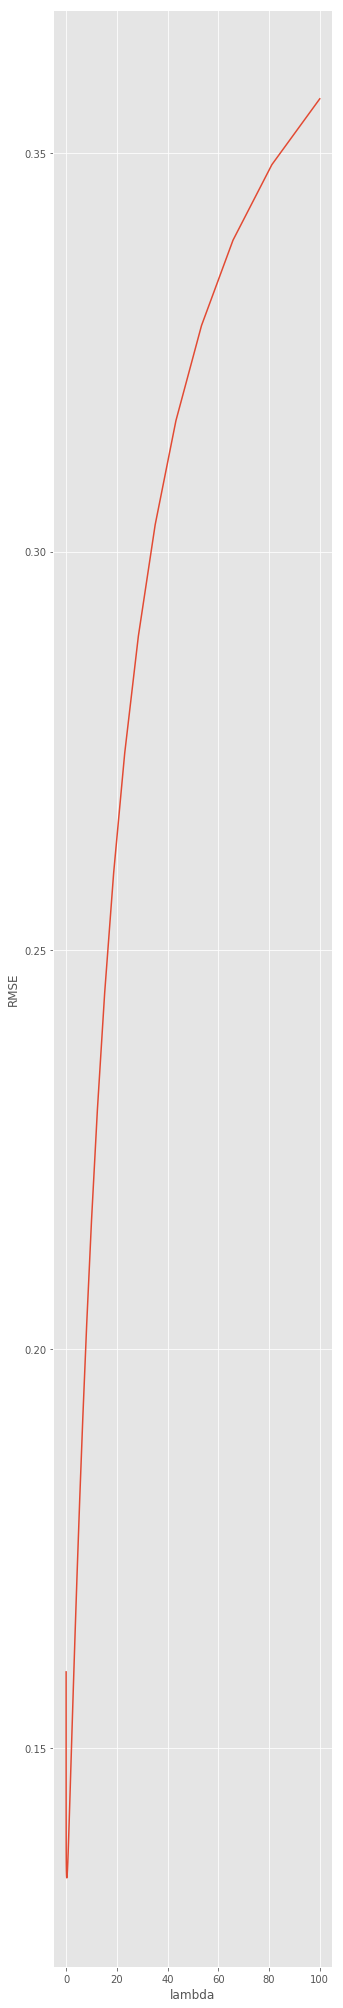

In [17]:
alphas = np.logspace(-7, 2, 100)

grid = GridSearchCV(estimator=Ridge(normalize=True),
    param_grid=dict(alpha=alphas), cv=5, scoring='neg_mean_squared_error' ) # scoring='r2'

grid.fit(df_train, df_train_label_log) # entire datasets were fed here

print (grid.best_params_, -grid.best_score_)

#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
scores = [np.sqrt(-x) for x in grid.cv_results_['mean_test_score'] ]
plt.plot(alphas, scores)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.show()

# the lambda is very small. Therefore, there is almost no regulization going on.

RMSE = 0.1553
RMSLE = 0.0117


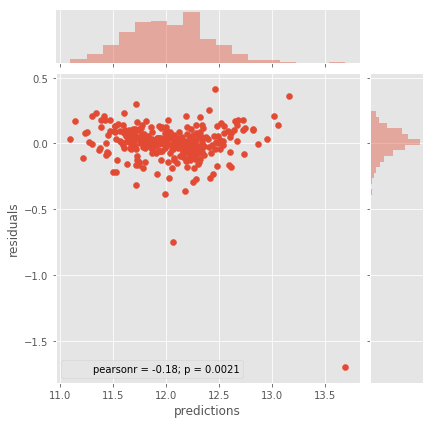

In [18]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=0)
model_ridge = Ridge(alpha= grid.best_params_['alpha'], normalize=True)
model_ridge.fit(X_train, y_train)

rmse, rmsle, pred = evaluate(model_ridge, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

In [19]:
model_ridge = Ridge(alpha= grid.best_params_['alpha'], normalize=True)
cvrmse = np.sqrt(-cross_val_score( model_ridge , df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10) )
cvrmse


array([0.12733703, 0.10017146, 0.12010831, 0.15901286, 0.14554976,
       0.10389862, 0.12762067, 0.10861294, 0.17386546, 0.13208277])

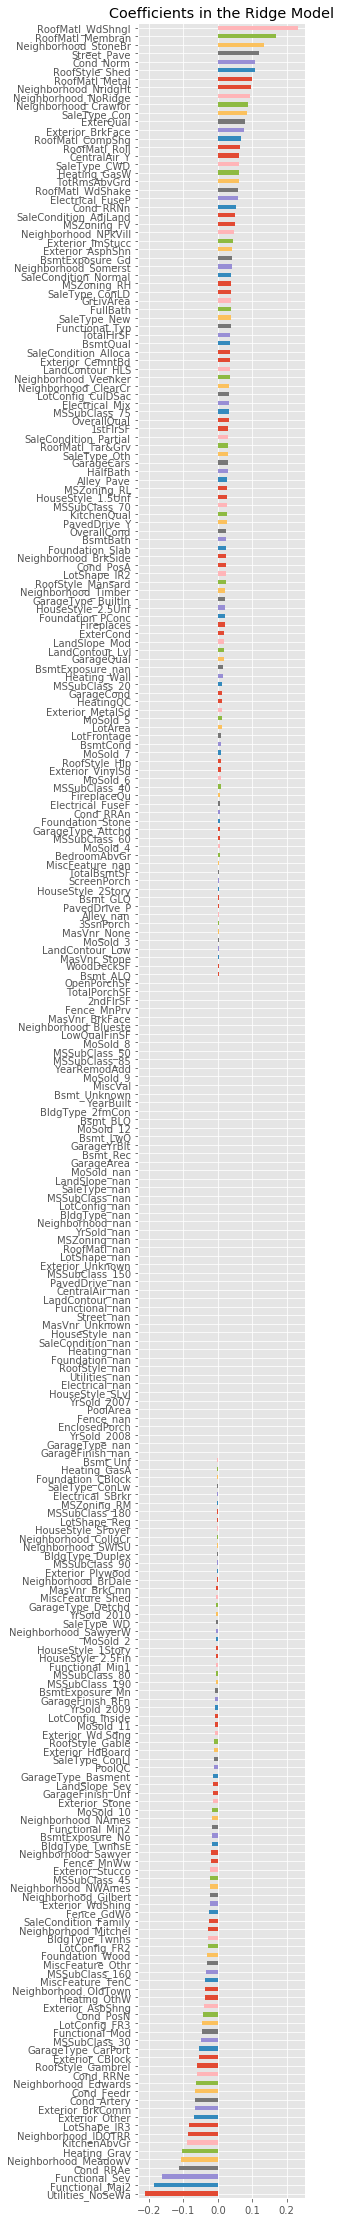

In [20]:
model_ridge.fit(df_train, df_train_label_log)
coef = pd.Series(model_ridge.coef_[0], index = df_train.columns)
plt.rcParams['figure.figsize'] = (3.0, 40.0)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.rcParams['figure.figsize'] = (3.0, 3.0)

In [21]:
model_ridge = Ridge(alpha= grid.best_params_['alpha'], normalize=True)
model_ridge.fit(df_train, df_train_label_log)

best_ridge_test_y = model_ridge.predict(df_test)
best_ridge_test_y = np.expm1(best_ridge_test_y)
sub['SalePrice'] = best_ridge_test_y
sub.to_csv('Ridge.csv')

ElasticNet

In [ ]:
grid_param = [{'alpha': np.logspace(-7, 3, 100), 
               'l1_ratio': np.arange(0.5, 1, 0.1)}]

grid = GridSearchCV(estimator=ElasticNet(normalize=True),
    param_grid=grid_param, cv=10, scoring='neg_mean_squared_error' ) # scoring='r2'

grid.fit(df_train, df_train_label_log ) # entire datasets were fed here

print (grid.best_params_, -grid.best_score_)

#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
model_elasticNet = ElasticNet(alpha= grid.best_params_['alpha'], l1_ratio = grid.best_params_['l1_ratio'], normalize=True)
model_elasticNet.fit(X_train, y_train)

rmse, rmsle, pred = evaluate(model_elasticNet, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

In [ ]:
model_elasticNet = ElasticNet(alpha= grid.best_params_['alpha'], l1_ratio = grid.best_params_['l1_ratio'], normalize=True)
cvrmse = np.sqrt(-cross_val_score( model_elasticNet , df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10) )

cvrmse.mean()



In [ ]:
model_elasticNet.fit(X_train, y_train)
coef = pd.Series(model_elasticNet.coef_, index = df_train.columns)
plt.rcParams['figure.figsize'] = (3.0, 40.0)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.rcParams['figure.figsize'] = (3.0, 3.0)

In [ ]:
model_elasticNet = ElasticNet(alpha= grid.best_params_['alpha'], l1_ratio = grid.best_params_['l1_ratio'], normalize=True)
model_elasticNet.fit(df_train, df_train_label_log)

best_elastic_test_y = model_elasticNet.predict(df_test)
best_elastic_test_y = np.expm1(best_elastic_test_y)
sub['SalePrice'] = best_elastic_test_y
sub.to_csv('Elastic.csv')

PLS -- Partial Least square regression.

In [ ]:
# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=0)

mse = []

from sklearn.preprocessing import scale 
from sklearn.cross_decomposition import PLSRegression, PLSSVD

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
    mse.append(-score)

    
# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Sale Price')
plt.xlim(xmin=-1)

In [ ]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))